# Convolutional Neural Networks in TensorFlow Week03

Transfer Learning

- 내가 가지고 있는 데이터셋은 너무 적고, 다른 사람이 이미 학습시킨 모델을 가져다 쓰고 싶을 때
- 웬만한 모델들은 케라스에 다 내장되어 있고, weight 만 다운로드 받아서 전체 혹은 일부를 로드해서 쓸 수 있음

Dropout

- 랜덤하게 일부 뉴런은 제외하고 학습 시킴
- 일부 뉴런에 웨이트가 몰리게 되면 오버피팅 가능성이 높아지기 때문

[inceptionv3 웨이트 다운로드](https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5)

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [3]:
local_weights_file = '../datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


- `layer.trainable`을 통해 학습을 시킬지 안시킬지 선택할 수 있음
- 내가 원하는 부분까지만 가져올 수 있음. 여기선 `mixed7` 레이어까지만 가져옴

In [4]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define our example directories and files
base_dir = '../datasets/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 14s - loss: 0.3725 - accuracy: 0.8545 - val_loss: 0.1249 - val_accuracy: 0.9480
Epoch 2/20
100/100 - 12s - loss: 0.2165 - accuracy: 0.9125 - val_loss: 0.1070 - val_accuracy: 0.9640
Epoch 3/20
100/100 - 12s - loss: 0.2104 - accuracy: 0.9230 - val_loss: 0.1278 - val_accuracy: 0.9560
Epoch 4/20
100/100 - 12s - loss: 0.1898 - accuracy: 0.9340 - val_loss: 0.1101 - val_accuracy: 0.9600
Epoch 5/20
100/100 - 12s - loss: 0.1639 - accuracy: 0.9400 - val_loss: 0.1730 - val_accuracy: 0.9420
Epoch 6/20
100/100 - 13s - loss: 0.1941 - accuracy: 0.9310 - val_loss: 0.1106 - val_accuracy: 0.9710
Epoch 7/20
100/100 - 14s - loss: 0.1560 - accuracy: 0.9450 - val_loss: 0.0908 - val_accuracy: 0.9720
Epoch 8/20
100/100 - 13s - loss: 0.1653 - accuracy: 0.9415 - val_loss: 0.1020 - val_accuracy: 0.9710
Epoch 9/20
100/100 - 14s - loss: 0.1541 - accuracy: 0.9465 - val_loss: 0.1527 - val_accuracy: 0.9590
Epoch 10/20
100/100 - 13s - loss: 0.1594 - accuracy: 0.9460 - val_loss: 0.1122 - val_accura

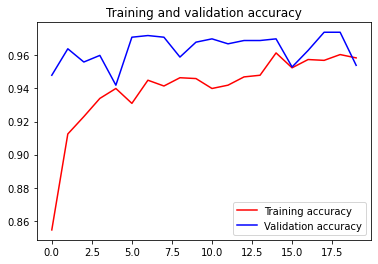

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()